# Topic Modeling

Run in terminal or command prompt
`python -m spacy download en`

The core packages used in this tutorial are `nltk`, `re`, `gensim`, `spacy` and `pyLDAvis`. Besides this we will also using `matplotlib`, `numpy`, `pandas` and `plotly` for data handling and visualization. Let’s import them.

(to install and run jupyter notebooks, see: <https://www.csestack.org/install-use-jupyter-notebook-python-example/>)

In [2]:
%%time
import nltk
nltk.download('stopwords')


CPU times: user 468 ms, sys: 163 ms, total: 631 ms
Wall time: 1.08 s


[nltk_data] Downloading package stopwords to /home/ab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We'll also need some libraries for data manipulation and visualization: `matplotlib`, `numpy` and `pandas`.

In [3]:
import re
import numpy
import pandas
pandas.set_option("display.max_colwidth", 30)
from pprint import pprint

In [4]:
# Gensim
import gensim
import gensim.corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Stopwords

In [5]:
%%time

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**NB:** however, it is always better to have your personal curated list. How can we create it? 

# Load our Dispatch data:

In [6]:
%%time

dispatchFile = "../../../Project/the-whole-dispatch.1.tsv" # or: dispatch_1864_filtered.tsv
dispatch = pandas.read_csv(dispatchFile, sep="\t", header=0)

# add a column with all dates of each month changed to 1 (we can use that to aggregate our data into months)
dispatch["month"] = [re.sub("-\d\d$", "-01", str(i)) for i in dispatch["date"]]

# reorder columns
dispatch = dispatch[["month", "date", "type", "header", "content"]]

CPU times: user 1.41 s, sys: 105 ms, total: 1.52 s
Wall time: 1.75 s


In [7]:
dispatch

,month,date,type,header,content
0,1860-02-01,1860-02-13,advert,"N. A. Sturdivant,Attorney ...","\n \n\n\n Office on 11th,..."
1,1860-02-01,1860-02-13,advert,NaN,\n \n\n\nDr. Geo. W. Brig...
2,1860-02-01,1860-02-13,advert,"Preston M. Quarles, Notary...","\n \n\n\n --As Notary, wi..."
3,1860-02-01,1860-02-13,advert,NaN,\nHenry Coalter Cabell.\n...
4,1860-02-01,1860-02-13,advert,"Edward E. Orvis,Attorney a...",\n \n\n\n Will attend pro...
...,...,...,...,...,...
338364,1865-12-01,1865-12-30,ad-blank,Steamers.,\n \n \n \n \n
338365,1865-12-01,1865-12-30,ad-blank,NaN,\n \n\n\n \n
338366,1865-12-01,1865-12-30,ad-blank,NaN,\n \n \n
338367,1865-12-01,1865-12-30,ad-blank,NaN,\n \n \n


In [8]:
%%time
dispatch["month"] = pandas.to_datetime(dispatch["month"], format="%Y-%d-%m")
dispatch["date"] = pandas.to_datetime(dispatch["date"], format="%Y-%d-%m")
dispatch.head(5)

ValueError: unconverted data remains: 3

In [9]:
# you can change the parameter below, but it may become messy if it is too large
# this parameter sets the width of columns
pandas.set_option("display.max_colwidth", 50)
dispatch.head(5)

,month,date,type,header,content
0,1860-01-02,1860-02-13,advert,"N. A. Sturdivant,Attorney at Law.Richmond, Va.","\n \n\n\n Office on 11th, between Main and Fr..."
1,1860-01-02,1860-02-13,advert,NaN,\n \n\n\nDr. Geo. W. Briggs offers his profes...
2,1860-01-02,1860-02-13,advert,"Preston M. Quarles, Notary public for the City...","\n \n\n\n --As Notary, will take depositions ..."
3,1860-01-02,1860-02-13,advert,NaN,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...
4,1860-01-02,1860-02-13,advert,"Edward E. Orvis,Attorney at Lawand Notary publ...",\n \n\n\n Will attend promptly to all busines...


The following checks data types in a dataframe (table). Let's run it to check if our "date" column was properly converted:

In [10]:
dispatch.dtypes

month      datetime64[ns]
date               object
type               object
header             object
content            object
dtype: object

The following line prints a specific piece of our table (a cell from the second row, column `text`):

In [11]:
print(dispatch["content"][1])

 
 


Dr. Geo. W. Briggs offers his professional services to the citizens of Richmond and vicinity.  


 Office next door to Ed. Eacho's, on 14th street, between Main and Franklin.  


 Residence--27th and Broad sts., Church Hill.  


 ja 29--3m   



The following command allows us to count instances of specific values in a specific column:

In [12]:
dispatch['type'].value_counts()

ad-blank      236125
article        70281
advert         18454
orders         10871
death           1025
               ...  
runaways           1
obituaries         1
alticle            1
sales              1
article            1
Name: type, Length: 94, dtype: int64

## Filtering your dataframe:

1. Range of rows or columns by index positions
2. Filtering by value(s)
3. And many other ways (for more examples, see, [this tutorial](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/))

In [13]:
len(dispatch)


338369

Range of rows or columns by index positions:

In [90]:
len(dispatch.loc[1:1000])

10000

Filtering by value(s):

In [98]:
dispatch_a = dispatch[dispatch.type != "ad-blank"]
dispatch_light = dispatch_a[dispatch_a.type != "adverb"]
# strip down
dispatch_light = dispatch_light.loc[1:10000]
len(dispatch_light)

7743

Filtering affects index numbers of rows in the table (they are in the leftmost "column"). If you scroll the table generated below, you will see that some numbers are missing. We need to reset them (or renumber) so that we could merge with topic data that we will generate later.

**NB**: reset can be done with the following command `dispatch_light_reset = dispatch_light.reset_index(drop=True)`

In [99]:
dispatch_light.head(20)

,month,date,type,header,content
1,1860-01-02,1860-02-13,advert,NaN,\n \n\n\nDr. Geo. W. Briggs offers his profes...
2,1860-01-02,1860-02-13,advert,"Preston M. Quarles, Notary public for the City...","\n \n\n\n --As Notary, will take depositions ..."
3,1860-01-02,1860-02-13,advert,NaN,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...
4,1860-01-02,1860-02-13,advert,"Edward E. Orvis,Attorney at Lawand Notary publ...",\n \n\n\n Will attend promptly to all busines...
5,1860-01-02,1860-02-13,advert,Shockoe Hill GeneralAgency.G. W. H. Tyler.,"\n \n\n\n Office on Marshall, between Sixth a..."
6,1860-01-02,1860-02-13,advert,"Henry Hudnall.,Attorney at Lawand Notary public,",\n \n\n\n Practices in all the Courts held in...
7,1860-01-02,1860-02-13,advert,"A Card.Wm. F. Watson.Attorney at Law,United St...","\n \n\n\n Note.--In the latter capacity, will..."
8,1860-01-02,1860-02-13,advert,"Lawrence S. Marye,Attorney at Law,",\n \n\n\n Practices in the Courts of the city...
9,1860-01-02,1860-02-13,advert,"Exchange Hotel and BallardHouse.Richmond, Janu...",\n \n\n\n The proprietors of this well-known ...
10,1860-01-02,1860-02-13,advert,"Spotswood House,Richmond, Va.","\n \n\n\n This new Hotel, at the corner of Ma..."


You can read/print the text of any item in the following manner: `your_dataframe["column_name"][row_number]`

In [100]:
print(dispatch_light["content"][786])

 
 


 Pat. Meal. Cox's sparkling Gelatine; Cooper's Isinglass and refined spread Isinglass; Chocolate; Cocoa; prepared Corn Starch; Tapioca; Sago; Arrow Root, &amp;c.  


 L. Wagner. Druggist.  
 Corner 6th and Broad sts.   



# Preparing our data

Do not rush to run the following code! There is a lot of data in the Dispatch and running all data may take quite a while. In class, let's use a smaller sample. At home, re-run this notebook with all the data (you can drop items of the type `ad-blank`).

In [101]:
%%time
dispatch_light.loc[:,"textData"] = dispatch_light["content"].copy()

CPU times: user 2.9 ms, sys: 0 ns, total: 2.9 ms
Wall time: 2.47 ms


In [102]:
%%time
# nb: each value needs to be converted into string explicitly
# you can clean up text more with the following command, but be careful
dispatch_light.loc[:,"textData"] = [re.sub("'|\"", "", str(i)) for i in dispatch_light["textData"].copy()]

CPU times: user 77.7 ms, sys: 91.8 ms, total: 170 ms
Wall time: 168 ms


In [103]:
dispatch_light.head()

,month,date,type,header,content,textData
1,1860-01-02,1860-02-13,advert,NaN,\n \n\n\nDr. Geo. W. Briggs offers his profes...,\n \n\n\nDr. Geo. W. Briggs offers his profes...
2,1860-01-02,1860-02-13,advert,"Preston M. Quarles, Notary public for the City...","\n \n\n\n --As Notary, will take depositions ...","\n \n\n\n --As Notary, will take depositions ..."
3,1860-01-02,1860-02-13,advert,NaN,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...
4,1860-01-02,1860-02-13,advert,"Edward E. Orvis,Attorney at Lawand Notary publ...",\n \n\n\n Will attend promptly to all busines...,\n \n\n\n Will attend promptly to all busines...
5,1860-01-02,1860-02-13,advert,Shockoe Hill GeneralAgency.G. W. H. Tyler.,"\n \n\n\n Office on Marshall, between Sixth a...","\n \n\n\n Office on Marshall, between Sixth a..."


# Tokenize and Clean Texts 

In [104]:
%%time
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

dispatch_light.loc[:,"textDataLists"] = list(sent_to_words(dispatch_light["textData"].copy()))

CPU times: user 1.45 s, sys: 31.7 ms, total: 1.49 s
Wall time: 1.49 s


In [105]:
dispatch_light["textDataLists"].head()

1    [dr, geo, briggs, offers, his, professional, s...
2    [as, notary, will, take, depositions, and, ack...
3    [henry, coalter, cabell, sands, cabell, amp, s...
4    [will, attend, promptly, to, all, business, pl...
5    [office, on, marshall, between, sixth, and, se...
Name: textDataLists, dtype: object

In [106]:
print(dispatch_light["content"][100]) # our original text

 
 


 --Having been kindly informed, by some of our patrons, that a report was in circulation, that we sold liquor by the small quantity, to be drank in the store, said report may have been put in circulation by interested parties, in order to injure us; or, the impression may have been made, on the minds of some, from an advertisement which was put in the Dispatch, previous to the holidays, headed Egg-Nog, Hot Whiskey Punch, &amp;c., which was only intended as a notice to the public that we had fine Irish Whiskey, Scotch Whiskey, and Jamaica Rum for sale, to those who wished to make the above drinks.  


 Be this as it may, we here say, that while we keep a choice stock of Brandies, Wines, Whiskeys, &amp;c., &amp;c., constantly on hand, we never have, or never intend to sell liquor of any kind to be drank in the store, while said business is under our control.

We have said this much as being due to ourselves, as well as to those who have so liberally patronized us.  


Minnis &amp; 

In [107]:
print(dispatch_light["textDataLists"][100]) # our `listed` text

['having', 'been', 'kindly', 'informed', 'by', 'some', 'of', 'our', 'patrons', 'that', 'report', 'was', 'in', 'circulation', 'that', 'we', 'sold', 'liquor', 'by', 'the', 'small', 'quantity', 'to', 'be', 'drank', 'in', 'the', 'store', 'said', 'report', 'may', 'have', 'been', 'put', 'in', 'circulation', 'by', 'interested', 'parties', 'in', 'order', 'to', 'injure', 'us', 'or', 'the', 'impression', 'may', 'have', 'been', 'made', 'on', 'the', 'minds', 'of', 'some', 'from', 'an', 'advertisement', 'which', 'was', 'put', 'in', 'the', 'dispatch', 'previous', 'to', 'the', 'holidays', 'headed', 'egg', 'nog', 'hot', 'whiskey', 'punch', 'amp', 'which', 'was', 'only', 'intended', 'as', 'notice', 'to', 'the', 'public', 'that', 'we', 'had', 'fine', 'irish', 'whiskey', 'scotch', 'whiskey', 'and', 'jamaica', 'rum', 'for', 'sale', 'to', 'those', 'who', 'wished', 'to', 'make', 'the', 'above', 'drinks', 'be', 'this', 'as', 'it', 'may', 'we', 'here', 'say', 'that', 'while', 'we', 'keep', 'choice', 'stock', 

# Creating a frequency list

## Identifying stop words and low frequency words

Why would we want/need to identify and remove these?

In [108]:
%%time

vocabList = [item for sublist in dispatch_light["textDataLists"] for item in sublist]

freqDic = {}
low_frequency_words = []

# collecting frequencies, like we did before
for v in vocabList:
    if v in freqDic:
        freqDic[v] += 1
    else:
        freqDic[v]  = 1

# reformatting collected results
freqList = []
for k,v in freqDic.items():
    val = "%09d\t%s\t0" % (v, k)
    freqList.append(val)
    # the cutoff value for low frequency items should be determined through the distribution of frequencies
    # but it is always safe to remove items that have frequency 1 (most likely typos)
    if v <= 1:
        low_frequency_words.append(k)

with open("./dispatch_freq_list.csv", "w", encoding="utf8") as f9:
    f9.write("\n".join(sorted(freqList, reverse=True)))

print("-"*50)
print("frequency_list")
print(len(freqList))    
print("low_frequency_words")
print(len(low_frequency_words))
print("-"*50)

--------------------------------------------------
frequency_list
22755
low_frequency_words
8616
--------------------------------------------------
CPU times: user 182 ms, sys: 3.28 ms, total: 185 ms
Wall time: 185 ms


In [109]:
print(low_frequency_words[100:200])

['abd', 'hamid', 'cosmopolitan', 'abode', 'mohammedan', 'mosque', 'caravanserai', 'koran', 'mindful', 'adage', 'saul', 'reassessment', 'oppenheimer', 'coghill', 'substituting', 'quisenbury', 'hebrew', 'mccamant', 'incorporation', 'smelting', 'appoints', 'acceding', 'adhering', 'reject', 'rann', 'gallanted', 'danced', 'feasted', 'tucked', 'snugly', 'sleigh', 'hatty', 'gaieties', 'footlights', 'wielded', 'cube', 'stow', 'aldermen', 'burging', 'prosecutor', 'kingstry', 'presentment', 'returnable', 'gwynn', 'convicting', 'chilton', 'unestimable', 'estimating', 'valuation', 'alms', 'fullest', 'burthens', 'extort', 'dilemma', 'contended', 'companionship', 'lockley', 'sullivan', 'edible', 'cabbaged', 'demolishment', 'intersects', 'cavity', 'penance', 'abstain', 'frivolity', 'peasley', 'surfeited', 'poulterers', 'decorations', 'busts', 'drapery', 'adornments', 'rosenberger', 'loebman', 'chose', 'waltzing', 'overpowering', 'fergusons', 'affaires', 'journalism', 'ethereal', 'meldrums', 'claret',

After this, you can work through the generated frequency list and mark those that you want to consider stop words in the third column by changing `0` to `1`. After that, we can use this file to load stop words and you will have, in case you want to reconsider what counts as a stop word. This approach will allow you to adjust your stop word list based on your corpus.

You should rename the frequency file so that it does not get overwritten when you re-run the script. 

In [110]:
with open("./dispatch_freq_list_manual.csv", "r", encoding="utf8") as f1:
    data = f1.read().split("\n")
    
    stop_words_custom = []
    
    for d in data:
        d = d.split("\t")
        if d[2] == "1":
            stop_words_custom.append(d[1])
 
stop_words_custom.extend(stop_words) # adding stop words from nltk
stop_words_custom = list(set(stop_words_custom))

print(stop_words_custom)

["she's", "should've", 'above', 'through', 'having', 'from', "mightn't", 'up', 'been', 'at', 'into', 'needn', 'she', "that'll", 'with', 'y', 'weren', "needn't", 'between', 'mustn', 'were', 'very', 'th', 'their', 'ma', "couldn't", 'it', 'herself', 'this', 'would', 'again', 'why', 'hasn', 'yourself', "isn't", 'itself', 'themselves', 'have', 'was', 'could', 'both', 'don', "shouldn't", 'nor', 'had', 's', 'or', 'so', 'those', 'yours', 'most', 'couldn', 'hadn', 'ourselves', 'our', 'other', 'they', 'each', 'off', 'as', 'has', 'your', 'shan', "you're", 'doing', 'once', 'aren', 'the', 'd', 'mightn', 'there', "aren't", 'her', 'yourselves', "you'd", "won't", 'because', "it's", 'over', 'his', 'to', 'are', 'will', 'won', 'out', "didn't", 'myself', 'own', 'before', 'an', 'below', 'some', "you'll", 'did', 'all', 'do', 'while', 'also', 'no', 'without', 'against', "don't", 'isn', 'what', 'shouldn', 'wasn', 'not', 'he', 'under', 'being', 'until', 'should', 'am', 'and', 'you', 'same', 'after', 'every', '

**NB:** One can also add bigrams and trigrams into the mix, before running topic modeling.

I have already prepared stopwords, let's use it:

In [33]:
stop_words_custom = ["the", "of", "and", "to", "in", "a", "that", "for", "on", "was", "is", "at", "be", "by",
                   "from", "his", "he", "it", "with", "as", "this", "will", "which", "have", "or", "are",
                   "they", "their", "not", "were", "been", "has", "our", "we", "all", "but", "one", "had",
                    "who", "an", "no", "i", "them", "about", "him", "two", "upon", "may", "there", "any",
                   "some", "so", "men", "when", "if", "day", "her", "under", "would", "c", "such", "made",
                   "up", "last", "j", "time", "years", "other", "into", "said", "new", "very", "five",
                   "after", "out", "these", "shall", "my", "w", "more", "its", "now", "before", "three",
                   "m", "than", "h", "o'clock", "old", "being", "left", "can", "s", "man", "only", "same",
                   "act", "first", "between", "above", "she", "you", "place", "following", "do", "per",
                   "every", "most", "near", "us", "good", "should", "having", "great", "also", "over",
                   "r", "could", "twenty", "people", "those", "e", "without", "four", "received", "p", "then",
                   "what", "well", "where", "must", "says", "g", "large", "against", "back", "000", "through",
                   "b", "off", "few", "me", "sent", "while", "make", "number", "many", "much", "give",
                   "1", "six", "down", "several", "high", "since", "little", "during", "away", "until",
                   "each", "5", "year", "present", "own", "t", "here", "d", "found", "reported", "2",
                   "right", "given", "age", "your", "way", "side", "did", "part", "long", "next", "fifty",
                   "another", "1st", "whole", "10", "still", "among", "3", "within", "get", "named", "f",
                   "l", "himself", "ten", "both", "nothing", "again", "n", "thirty", "eight", "took",
                   "never", "came", "called", "small", "passed", "just", "brought", "4", "further",
                   "yet", "half", "far", "held", "soon", "main", "8", "second", "however", "say",
                   "heavy", "thus", "hereby", "even", "ran", "come", "whom", "like", "cannot", "head",
                   "ever", "themselves", "put", "12", "cause", "known", "7", "go", "6", "once", "therefore",
                   "thursday", "full", "apply", "see", "though", "seven", "tuesday", "11", "done",
                   "whose", "let", "how", "making", "immediately", "forty", "early", "wednesday",
                   "either", "too", "amount", "fact", "heard", "receive", "short", "less", "100",
                   "know", "might", "except", "supposed", "others", "doubt", "set", "works"]

# Text cleaning

In [111]:
def remove_words(texts, word_list_filter):
    return [[word for word in simple_preprocess(str(doc)) if word not in word_list_filter] for doc in texts]

Removing `low_frequency_words` is going to take a while, so it is currently commented out. Run this at home.

In [112]:
dispatch_light.loc[:,"textDataListsFiltered"] = remove_words(dispatch_light["textDataLists"], stop_words_custom)
dispatch_light.loc[:,"textDataListsFiltered"] = remove_words(dispatch_light["textDataListsFiltered"], low_frequency_words)


In [113]:
dispatch_light["textDataLists"].head()

1    [dr, geo, briggs, offers, his, professional, s...
2    [as, notary, will, take, depositions, and, ack...
3    [henry, coalter, cabell, sands, cabell, amp, s...
4    [will, attend, promptly, to, all, business, pl...
5    [office, on, marshall, between, sixth, and, se...
Name: textDataLists, dtype: object

In [114]:
dispatch_light["textDataListsFiltered"].head()

1    [dr, geo, briggs, offers, professional, servic...
2    [notary, take, depositions, acknowledgments, a...
3    [henry, coalter, cabell, sands, cabell, amp, s...
4    [attend, promptly, business, placed, hands, of...
5    [office, marshall, sixth, seventh, streets, co...
Name: textDataListsFiltered, dtype: object

# Create the Dictionary and Corpus needed for Topic Modeling

In [115]:
%%time
# Create Dictionary
dictionary = gensim.corpora.Dictionary(dispatch_light["textDataListsFiltered"])

# Create Corpus
texts = dispatch_light["textDataListsFiltered"]

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts] # bow == bag of words

# View
print(corpus[:3])
print("-"*50)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(15, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)], [(12, 1), (15, 1), (18, 2), (20, 1), (26, 1), (33, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)]]
--------------------------------------------------
CPU times: user 646 ms, sys: 20.6 ms, total: 667 ms
Wall time: 668 ms


This list above is a text: every tuple (like `(0, 1)`) represents a word (first number) and its frequency (second number). We can check which word is hiding behind a number by:

In [116]:
dictionary[3]

'citizens'

# Building the Topic Model

The following step takes quite a lot of time, so do not run it in class. You may want to leave it running overnight. Ideally, the number of passes should be at least a hundred—this increases the stability of topics, but also increases the amount of time required for generating the model. Good news is that you do not have to train the model every time: you can save it and load everytime you want to use it.


On all the data, with 5 passes it took:
```
CPU times: user 44min 56s, sys: 7.42 s, total: 45min 4s
Wall time: 7min 56s
```

On only 1864, with 100 passes and 20 updates:

```
CPU times: user 21min 46s, sys: 1min 35s, total: 23min 21s
Wall time: 9min 21s
```

**NB:** You can comment out the entire chunk by selecting it and pressing `Ctrl+/` on Windows or `Cmd+/` on Mac. Pressing these combinations again will make code runnable again.

In [123]:
number_of_topics = 30

In [124]:
%%time
# Build LDA model
#number_of_topics = 30
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=number_of_topics,
                                   update_every=20,
                                   passes=100,
                                   alpha='auto')
print("-"*50)
path = "./models_new/"
lda_model.save(path+'dispatch_1864.lda')

--------------------------------------------------
CPU times: user 12min 51s, sys: 5min 55s, total: 18min 46s
Wall time: 5min 47s


These are just a couple of lines of code for saving your model; since we are not generating one, they are commented out.

In [125]:
path = "./models_new/"
lda_model.save(path+'dispatch1864.lda')

This line loads pre-generated model:

In [126]:
lda_model = gensim.models.LdaModel.load(path+'dispatch_1864.lda')

# View generated topics

In [127]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(14,
  '0.019*"remedy" + 0.018*"great" + 0.015*"diuretic" + 0.015*"standing" + '
  '0.014*"long" + 0.013*"cure" + 0.012*"extract" + 0.012*"ladies" + '
  '0.012*"buchu" + 0.011*"helmbolds"'),
 (25,
  '0.025*"breckinridge" + 0.025*"bell" + 0.020*"douglas" + 0.017*"majority" + '
  '0.017*"co" + 0.011*"counties" + 0.011*"official" + 0.010*"county" + '
  '0.010*"vote" + 0.008*"stock"'),
 (10,
  '0.025*"per" + 0.021*"cents" + 0.016*"virginia" + 0.016*"stock" + '
  '0.014*"bbls" + 0.014*"oil" + 0.013*"sales" + 0.011*"amp" + 0.010*"bonds" + '
  '0.010*"richings"'),
 (29,
  '0.023*"st" + 0.015*"main" + 0.011*"amp" + 0.008*"broad" + 0.008*"late" + '
  '0.008*"surgical" + 0.008*"sale" + 0.007*"styles" + 0.007*"meade" + '
  '0.007*"week"'),
 (11,
  '0.018*"week" + 0.017*"patients" + 0.015*"per" + 0.013*"persons" + '
  '0.011*"rooms" + 0.010*"private" + 0.010*"white" + 0.010*"medical" + '
  '0.008*"st" + 0.008*"physicians"'),
 (27,
  '0.020*"street" + 0.012*"main" + 0.012*"cts" + 0.008*"teeth" + 0

How can we infer topics?

# Optimal Topic Number

The common practice is to generate several models and calculate `coherence score` (*k*) for them all—the number with the highest `coherence score` is considered optimal.

**NB**: Do not run the code below during the class, as it may take over 20 mins to complete only when used with 1864 data; results are below in a table.

**NB:** You can comment out the entire chunk by selecting it and pressing `Ctrl+/` on Windows or `Cmd+/` on Mac. Pressing these combinations again will make code runnable again.

In [129]:
%%time

for num in range(2, 40, 4):
    lda_model_temp = gensim.models.LdaModel(corpus=corpus,id2word=dictionary,
                                   num_topics=num, update_every=1, passes=1, alpha='auto')
    coherence_model_lda = CoherenceModel(model=lda_model_temp,texts=dispatch_light["textDataListsFiltered"],
                                     dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score for %d topics: ' % num, coherence_lda)
    
print("-"*50)    

Coherence Score for 2 topics:  0.3484652219309665
Coherence Score for 6 topics:  0.4200037654459848
Coherence Score for 10 topics:  0.3579533909453332
Coherence Score for 14 topics:  0.36309270018553724
Coherence Score for 18 topics:  0.37525638447389076
Coherence Score for 22 topics:  0.38803388145172213
Coherence Score for 26 topics:  0.413486016845448
Coherence Score for 30 topics:  0.34881852614991776
Coherence Score for 34 topics:  0.37876086002042625
Coherence Score for 38 topics:  0.39461014775451003
--------------------------------------------------
CPU times: user 1min 13s, sys: 23.5 s, total: 1min 37s
Wall time: 1min 6s


It looks like 20 is the optimal number. Choosing the highest `coherence score` (often referred to as *k*) usually offers meaningful and interpretable topics. Yet, increasing the number of topics can sometimes provide more granular sub-topics.

**NB:** This information, however, is based only on 1864, not the entire run.

| *n* of topics  | coherence score |
| :------------:| ---------------:|
| 02 topics |   0.323452271212917 |
| 08 topics |   0.526666861582071 |
| 14 topics |   0.533737136756214 |
| **20 topics** |   **0.550748380632858** |
| 26 topics |   0.523267186487719 |
| 32 topics |   0.524391161619200 |
| 38 topics |   0.517618656947555 |

# Visualize topic-keywords

`pyLDAvis` library offers a visual tool for exploring topics. **λ-parameter** is designed to "slice" topics words in such a way that topics would be easier to interpret. If you slide this parameter below 1, you will see that the selection of words changes and if you reach 0, only words unique to this topic will be shown.

**NB:** Keep in mind that on the visualization below topics are numbered from 1 to 20, not from 0 to 19 as in the data!

In [130]:
import pyLDAvis.gensim

In [131]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/home/ab/Uni/2019W/Tools/python-scripts/.venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26     0.201412  0.182953       1        1  8.515550
2      0.041742 -0.173234       2        1  6.999181
24     0.195027  0.136601       3        1  5.465129
6      0.174588  0.012720       4        1  4.929238
23    -0.218087  0.097274       5        1  4.770684
3     -0.161923  0.151760       6        1  4.575382
1      0.199279  0.041051       7        1  4.235716
8      0.225868  0.028580       8        1  4.167234
13     0.022239 -0.200675       9        1  3.677657
0     -0.190587  0.047214      10        1  3.359592
17     0.027739  0.016010      11        1  3.327706
15    -0.055950 -0.082614      12        1  3.215659
10    -0.093349  0.019940      13        1  3.159924
12    -0.135931  0.075752      14        1  3.024631
11    -0.042061 -0.015579      15        1  2.906144
4      0.198614  0.088473      16        1  2.742028
18     0.033267 -0.095314      17        1  2.731114
7     -0.030952 -0.096218      18        1  2.703804
28    -0.028971 -0.014671      19        1  2.669471
20    -0.009578 -0.152655      20        1  2.432825
21    -0.121058  0.066050      21        1  2.288582
19    -0.032984 -0.067534      22        1  2.253728
29    -0.132678  0.015335      23        1  2.202251
16    -0.105315 -0.009167      24        1  2.175992
5     -0.070818 -0.042601      25        1  2.162203
22     0.031953 -0.162755      26        1  2.117065
27    -0.027883  0.015099      27        1  1.986438
9      0.202326 -0.030660      28        1  1.829295
25    -0.015172  0.014814      29        1  1.733027
14    -0.080759  0.134053      30        1  1.642750, topic_info=     Category         Freq    Term        Total  loglift  logprob
26    Default  4825.000000     amp  4825.000000  30.0000  30.0000
1423  Default  1063.000000    feet  1063.000000  29.0000  29.0000
3261  Default   587.000000     mrs   587.000000  28.0000  28.0000
295   Default  2131.000000    sale  2131.000000  27.0000  27.0000
250   Default  1601.000000      co  1601.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
20    Topic30    63.903255  street  2244.494629   0.5499  -4.6856
3172  Topic30    46.529560   goods  1257.298340   0.8122  -5.0029
12    Topic30    47.601933    main  1904.289185   0.4198  -4.9801
26    Topic30    45.645988     amp  4825.205566  -0.5519  -5.0221
404   Topic30    39.419128    call   841.185608   1.0482  -5.1687

[2270 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
5887       1  0.957464       abide
11634     15  0.065828   abilities
11634     26  0.855767   abilities
5820      21  0.925763      abneys
6019      18  0.047456   absconded
...      ...       ...         ...
1109      26  0.060590       young
1109      28  0.042413       young
7458       4  0.946972  zanesville
5117       6  0.208727      zouave
5117      30  0.775272      zouave

[7316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 3, 25, 7, 24, 4, 2, 9, 14, 1, 18, 16, 11, 13, 12, 5, 19, 8, 29, 21, 22, 20, 30, 17, 6, 23, 28, 10, 26, 15])

# Let's explore our topics more

In [132]:
dispatch_light.head()

,month,date,type,header,content,textData,textDataLists,textDataListsFiltered
1,1860-01-02,1860-02-13,advert,NaN,\n \n\n\nDr. Geo. W. Briggs offers his profes...,\n \n\n\nDr. Geo. W. Briggs offers his profes...,"[dr, geo, briggs, offers, his, professional, s...","[dr, geo, briggs, offers, professional, servic..."
2,1860-01-02,1860-02-13,advert,"Preston M. Quarles, Notary public for the City...","\n \n\n\n --As Notary, will take depositions ...","\n \n\n\n --As Notary, will take depositions ...","[as, notary, will, take, depositions, and, ack...","[notary, take, depositions, acknowledgments, a..."
3,1860-01-02,1860-02-13,advert,NaN,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...,"[henry, coalter, cabell, sands, cabell, amp, s...","[henry, coalter, cabell, sands, cabell, amp, s..."
4,1860-01-02,1860-02-13,advert,"Edward E. Orvis,Attorney at Lawand Notary publ...",\n \n\n\n Will attend promptly to all busines...,\n \n\n\n Will attend promptly to all busines...,"[will, attend, promptly, to, all, business, pl...","[attend, promptly, business, placed, hands, of..."
5,1860-01-02,1860-02-13,advert,Shockoe Hill GeneralAgency.G. W. H. Tyler.,"\n \n\n\n Office on Marshall, between Sixth a...","\n \n\n\n Office on Marshall, between Sixth a...","[office, on, marshall, between, sixth, and, se...","[office, marshall, sixth, seventh, streets, co..."


We can remove columns (we have too many of them now) in the following manner (numbers refer to the ordinal number of columns; counting from zero!):

In [133]:
dispatch_lightest = dispatch_light.drop(dispatch_light.columns[[6, 7]], axis=1)
dispatch_lightest.head()

,month,date,type,header,content,textData
1,1860-01-02,1860-02-13,advert,NaN,\n \n\n\nDr. Geo. W. Briggs offers his profes...,\n \n\n\nDr. Geo. W. Briggs offers his profes...
2,1860-01-02,1860-02-13,advert,"Preston M. Quarles, Notary public for the City...","\n \n\n\n --As Notary, will take depositions ...","\n \n\n\n --As Notary, will take depositions ..."
3,1860-01-02,1860-02-13,advert,NaN,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...
4,1860-01-02,1860-02-13,advert,"Edward E. Orvis,Attorney at Lawand Notary publ...",\n \n\n\n Will attend promptly to all busines...,\n \n\n\n Will attend promptly to all busines...
5,1860-01-02,1860-02-13,advert,Shockoe Hill GeneralAgency.G. W. H. Tyler.,"\n \n\n\n Office on Marshall, between Sixth a...","\n \n\n\n Office on Marshall, between Sixth a..."


In [137]:
number_of_topics = 30

## `get_document_topics` for the entire corpus

You can get `doc_topics`, `word_topics` and `phi_values` (probabilities of words for topics) for all the documents in the corpus in the following manner:

In [138]:
%%time
all_topics = lda_model.get_document_topics(corpus, per_word_topics=True)
print("-"*50)

--------------------------------------------------
CPU times: user 865 µs, sys: 0 ns, total: 865 µs
Wall time: 649 µs


Let's print out data for the first document:

In [139]:
%%time

for doc_topics, word_topics, phi_values in all_topics[:1]:
    print('New Document')
    print('\nDocument topics:', doc_topics)
    print('\nWord topics:', word_topics)
    print('\nPhi values:', phi_values)
    #print(" ")
    print('-------------- \n')

print("-"*50)

New Document

Document topics: [(6, 0.08902816), (7, 0.079364), (12, 0.53893304), (20, 0.27528057)]

Word topics: [(0, [20]), (1, [12, 20, 6]), (2, [6]), (3, [12, 6]), (4, [12, 6]), (5, [12, 20, 6]), (6, [7]), (7, [20, 12]), (8, [20, 12, 7]), (9, [20, 6]), (10, [20, 6]), (11, [12, 7, 20]), (12, [12, 20, 7]), (13, [12, 6]), (14, [12, 20]), (15, [12, 7, 20, 6]), (16, [12]), (17, [20, 12, 7]), (18, [12, 7, 20, 6]), (19, [12, 6]), (20, [12, 20, 7, 6]), (21, [12, 20]), (22, [12])]

Phi values: [(0, [(20, 0.99911463)]), (1, [(6, 0.02955524), (12, 0.8168769), (20, 0.15350613)]), (2, [(6, 0.9995749)]), (3, [(6, 0.08689495), (12, 0.9129578)]), (4, [(6, 0.24851474), (12, 0.75100046)]), (5, [(6, 0.017782647), (12, 0.64270395), (20, 0.33949098)]), (6, [(7, 0.98507404)]), (7, [(12, 0.09938827), (20, 0.9001804)]), (8, [(7, 0.09621509), (12, 0.43426248), (20, 0.46945757)]), (9, [(6, 0.030473849), (20, 0.9694414)]), (10, [(6, 0.07196228), (20, 0.92792714)]), (11, [(7, 0.122986816), (12, 0.84296966), (

Let's build a dataframe with topic values for every item (article) from the Dispatch. This will allow us to do more interesting things.

**NB:** for the entire run of Dispatch it took:
```
--------------------------------------------------
CPU times: user 26min 26s, sys: 3min 20s, total: 29min 46s
Wall time: 16min 3s
```

In [140]:
%%time

topicTableCols = [] # empty table for topic values (technically, a list still)
topicDic = {} # a dictionary with top words per topic

for i in range(0, number_of_topics, 1):
    tVal = "t%02d" % i
    topicTableCols.append(tVal)
    
    topicVals  = lda_model.show_topic(i)
    topicWords = ", ".join([word for word, prob in topicVals])
    topicDic[tVal] = topicWords


CPU times: user 27.4 ms, sys: 7.69 ms, total: 35.1 ms
Wall time: 33.1 ms


In [141]:
pprint(topicDic)

{'t00': 'amp, main, co, sale, store, brushes, street, rheumatism, medicines, '
        'best',
 't01': 'new, one, last, time, night, mr, take, morning, little, old',
 't02': 'sale, day, amp, terms, fair, auction, one, sell, house, oclock',
 't03': 'goods, ladies, amp, prices, stock, black, new, fine, large, cloaks',
 't04': 'one, made, mr, day, night, last, well, man, virginia, principal',
 't05': 'bbls, sale, wm, amp, new, richmond, hhds, extra, sons, york',
 't06': 'washington, state, states, new, mr, house, nov, convention, day, '
        'carolina',
 't07': 'richmond, office, leave, daily, express, city, expresses, new, '
        'courts, streets',
 't08': 'mr, messrs, two, one, company, col, regiment, last, number, capt',
 't09': 'yesterday, court, mayor, john, last, charge, night, found, morning, '
        'saturday',
 't10': 'per, cents, virginia, stock, bbls, oil, sales, amp, bonds, richings',
 't11': 'week, patients, per, persons, rooms, private, white, medical, st, '
        

The following step may take a couple minutes.

- Here were creating an empty row (filled with zeros) for each document in our corpus
- then we loop through all topic values for every given document
- and feed existing values into our row with zeros (if we have a value, it will replace a zero)
- you can uncomment `print` lines in the code below to see the steps of the process

In [142]:
%%time

topicTableRows = [] # now we are feeding topic values into our empty table

for doc_topics, word_topics, phi_values in all_topics:
    rawRow = [0] * number_of_topics
    #print(rawRow)
    #print(doc_topics)
    for t in doc_topics:
        #print(t)
        rawRow[t[0]] = t[1]
    #input(rawRow)
    topicTableRows.append(rawRow)

print("-"*50)

--------------------------------------------------
CPU times: user 27 s, sys: 5.78 s, total: 32.7 s
Wall time: 19.6 s


So, our corpus table length:

In [143]:
len(dispatch_lightest)

7743

And our topic table length:

In [144]:
len(topicTableRows)

7743

We just need to convert it into a proper dataframe format:

In [145]:
topicTable = pandas.DataFrame(topicTableRows, columns=topicTableCols)
topicTable.head(15)

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.088916,0.079428,0.0,0.000000,...,0.275306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.000000,0.066974,0.000000,0.000000,0.0,0.0,0.191098,0.681389,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.984757,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.233837,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.097991,...,0.000000,0.205206,0.204873,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.985243,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.972160,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.981768,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
8,0.000000,0.000000,0.179856,0.000000,0.0,0.0,0.000000,0.137641,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.199006,0.035929,0.182181,0.0,0.000000,0.0
9,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


While our topic table has the same dimensions (number of rows) as our Dispatch data, the rows in the topic table are indexed differently (starting from 0, while the Dispatch data starts from 1). We need to fix that before we can join topics table to the Dispatch data. Since default count in Python is from 0, it is easier to reset the Dispatch data like this:

In [146]:
dispatch_lightest = dispatch_lightest.reset_index(drop=True)
dispatch_lightest.head(15)

,month,date,type,header,content,textData
0,1860-01-02,1860-02-13,advert,NaN,\n \n\n\nDr. Geo. W. Briggs offers his profes...,\n \n\n\nDr. Geo. W. Briggs offers his profes...
1,1860-01-02,1860-02-13,advert,"Preston M. Quarles, Notary public for the City...","\n \n\n\n --As Notary, will take depositions ...","\n \n\n\n --As Notary, will take depositions ..."
2,1860-01-02,1860-02-13,advert,NaN,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...
3,1860-01-02,1860-02-13,advert,"Edward E. Orvis,Attorney at Lawand Notary publ...",\n \n\n\n Will attend promptly to all busines...,\n \n\n\n Will attend promptly to all busines...
4,1860-01-02,1860-02-13,advert,Shockoe Hill GeneralAgency.G. W. H. Tyler.,"\n \n\n\n Office on Marshall, between Sixth a...","\n \n\n\n Office on Marshall, between Sixth a..."
5,1860-01-02,1860-02-13,advert,"Henry Hudnall.,Attorney at Lawand Notary public,",\n \n\n\n Practices in all the Courts held in...,\n \n\n\n Practices in all the Courts held in...
6,1860-01-02,1860-02-13,advert,"A Card.Wm. F. Watson.Attorney at Law,United St...","\n \n\n\n Note.--In the latter capacity, will...","\n \n\n\n Note.--In the latter capacity, will..."
7,1860-01-02,1860-02-13,advert,"Lawrence S. Marye,Attorney at Law,",\n \n\n\n Practices in the Courts of the city...,\n \n\n\n Practices in the Courts of the city...
8,1860-01-02,1860-02-13,advert,"Exchange Hotel and BallardHouse.Richmond, Janu...",\n \n\n\n The proprietors of this well-known ...,\n \n\n\n The proprietors of this well-known ...
9,1860-01-02,1860-02-13,advert,"Spotswood House,Richmond, Va.","\n \n\n\n This new Hotel, at the corner of Ma...","\n \n\n\n This new Hotel, at the corner of Ma..."


Now, we can merge them without any issues:

In [147]:
mergedTable = pandas.concat([dispatch_lightest, topicTable], axis=1, sort=False)
len(mergedTable)

7743

In [148]:
mergedTable

,month,date,type,header,content,textData,t00,t01,t02,t03,...,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29
0,1860-01-02,1860-02-13,advert,NaN,\n \n\n\nDr. Geo. W. Briggs offers his profes...,\n \n\n\nDr. Geo. W. Briggs offers his profes...,0.0,0.000000,0.0,0.0,...,0.275306,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,1860-01-02,1860-02-13,advert,"Preston M. Quarles, Notary public for the City...","\n \n\n\n --As Notary, will take depositions ...","\n \n\n\n --As Notary, will take depositions ...",0.0,0.066974,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,1860-01-02,1860-02-13,advert,NaN,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...,\nHenry Coalter Cabell.\n\nJ. H. Sands.Cabell...,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,1860-01-02,1860-02-13,advert,"Edward E. Orvis,Attorney at Lawand Notary publ...",\n \n\n\n Will attend promptly to all busines...,\n \n\n\n Will attend promptly to all busines...,0.0,0.233837,0.0,0.0,...,0.000000,0.205206,0.204873,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,1860-01-02,1860-02-13,advert,Shockoe Hill GeneralAgency.G. W. H. Tyler.,"\n \n\n\n Office on Marshall, between Sixth a...","\n \n\n\n Office on Marshall, between Sixth a...",0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7738,1860-01-11,1860-11-26,advert,NaN,"\n \n\n\nP. Weilbacher, Wm. Paul, \nof Richm...","\n \n\n\nP. Weilbacher, Wm. Paul, \nof Richm...",0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.263444,0.0,0.0,0.0,0.0,0.000000,0.0
7739,1860-01-11,1860-11-26,advert,"Robert Wendenburg,","\n \n\n\nship Broker, Commission and \n\n\nF...","\n \n\n\nship Broker, Commission and \n\n\nF...",0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
7740,1860-01-11,1860-11-26,article,$20 reward.,\n \n\n\n --Escaped from Mr. Benjamin Davis J...,\n \n\n\n --Escaped from Mr. Benjamin Davis J...,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.994657,0.0
7741,1860-01-11,1860-11-26,article,$20 reward.,"\n \n\n\n --Ran away on Saturday, the 3d inst...","\n \n\n\n --Ran away on Saturday, the 3d inst...",0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.994904,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [149]:
mergedTable["content"][394]

" \n \n\n\nFor Rent--A fine Wood or Coal Yard, adjoining Wm. Gray's store, on the Canal, near the Armory.\n\nIt will hold fifty thousand bushels coal.\n\nPossession given the 1st January next.--Apply to [oc 29--1m] Wm. Gray.\n\nof R.   \n"

# Graphing topics over time

One of the most interesting things that we can do with data like ours is to check how topics are distributed over time. Our data is already prepared for this, we only need to summarize topics values by days or months before we can graph them (for more [details](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)). `pandas` library has all we need, but there many specialized graphing libraries that may produce better visual results. (For more details, check this [overview](https://www.shanelynn.ie/plotting-with-python-and-pandas-libraries-for-data-visualisation/))

In [150]:
topicSum = mergedTable.groupby("date").sum().copy()
topicSum["date"] = topicSum.index
topicSum.head()

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t21,t22,t23,t24,t25,t26,t27,t28,t29,date
date,,,,,,,,,,,,,,,,,,,,,
1860-02-13,11.547841,8.969576,4.384787,9.959778,9.041194,7.094381,14.146168,10.028889,16.275581,5.437777,...,6.565423,7.235219,10.172650,10.255226,2.929230,10.470887,5.276558,2.640792,3.401364,1860-02-13
1860-11-01,24.701655,15.320524,20.688137,26.800761,9.507876,19.724983,12.162148,17.212000,12.565421,9.269004,...,12.022841,10.105459,52.390503,15.167048,5.948738,8.425576,12.326523,18.439652,15.895457,1860-11-01
1860-11-02,34.497866,13.403440,24.752271,29.837357,10.644605,35.999504,12.663689,17.339759,13.290537,6.110515,...,13.310257,9.942564,60.870232,17.311889,6.737040,9.096448,10.890201,17.961434,16.340556,1860-11-02
1860-11-03,25.648969,12.454383,26.599497,24.317126,11.877466,23.699603,13.301183,15.368058,14.506896,8.228682,...,12.235937,11.043794,50.163584,16.538452,8.237454,14.264497,10.044558,16.511435,10.895197,1860-11-03
1860-11-05,27.861943,16.000815,23.737720,24.907908,11.176312,26.568657,14.732040,14.665108,11.969213,11.152809,...,13.051386,6.821220,46.726264,13.580639,8.727424,8.876288,11.135354,15.535345,14.109067,1860-11-05


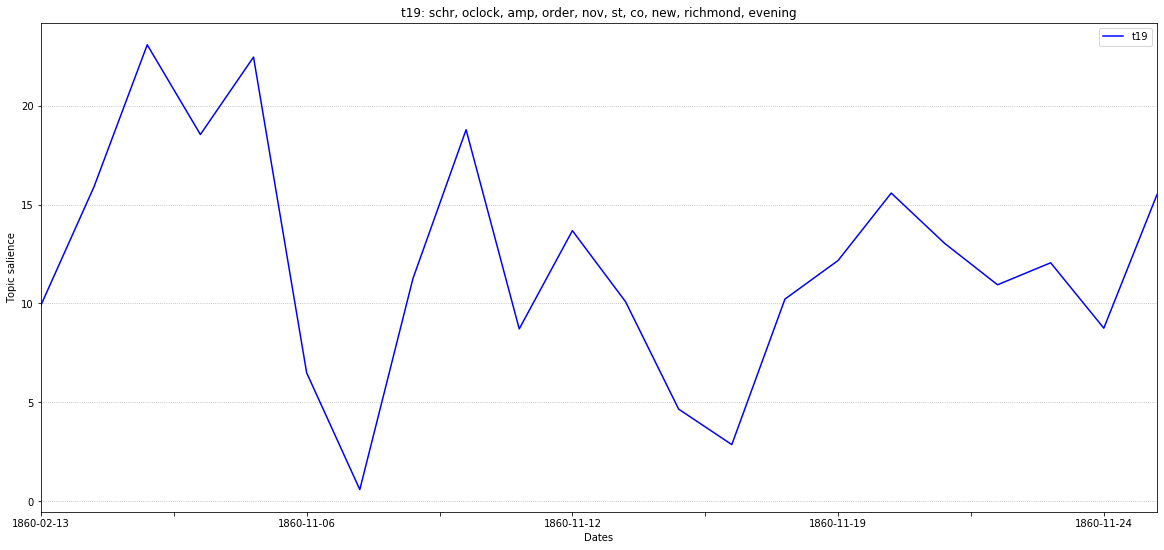

In [151]:
topic = "t19"

# Plotting directly from DataFrames with Pandas
topicSum.plot(
    x='date', 
    y=topic,  
    legend=True, 
    color='blue'
)
# The plot is now created, and we use Matplotlib style
# commands to enhance the output.
plt.rcParams["figure.figsize"] = (20,9)
plt.ylabel("Topic salience")
plt.xlabel("Dates")
plt.title(topic+": "+topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

You can run the cell below to print out items most representative of this topic.

In [152]:
temp = mergedTable[mergedTable[topic] > 0.95].sort_values(by=topic, ascending=False)
temp[["date", "content", topic]].head(15)

,date,content,t19
6245,1860-11-22,\n \n\n\n arrived \n\n\n Schr. Dan'l Townsen...,0.994648
3421,1860-11-12,"\n \n\n\n Holmes' Hole. Nov.\n\n--Sl'd, schr....",0.993948
2059,1860-11-05,"\n \n\n\n --300 boxes Raisins, in different s...",0.993339
6072,1860-11-21,"\n \n\n\n --300 boxes Raisins, in different s...",0.993339
6522,1860-11-22,"\n \n\n\n --300 boxes Raisins, in different s...",0.993339
2841,1860-11-09,"\n \n\n\n--300 boxes Raisins, in different si...",0.993339
329,1860-11-01,"\nHdq'rs Chesterfield Lt.Dragoons, Co. ""a"" 23...",0.993339
5399,1860-11-20,"\n \n\n\n --300 boxes Raisings, in different ...",0.993142
1659,1860-11-03,"\n \n\n\n --300 boxes Raising, in different s...",0.992823
1484,1860-11-03,"\n Manchester, October 31st. 1860. \n\n\nPa...",0.992593


And you can check individual items like this:

In [153]:
mergedTable["content"][75]

' \n \n\n\n 50 bbls. Extra C. Sugar 75 bbs. Cut Loaf Sugar, landing, for sale.  \n\n\n ja 20 Lewis Webb &amp; John G. Wade.   \n'

We can also use `plotly` library to generat dynamic graphs:

In [154]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [155]:
# Create the data for the bar chart
bar_data = go.Bar(
    x=topicSum["date"], 
    y=topicSum[topic]
)
# Create the layout information for display
layout = go.Layout(
    title=topic+": "+topicDic[topic],    
    xaxis=dict(title='Dates'),
    yaxis=dict(title='Topic Salience')
)
# These two together create the "figure"
figure = go.Figure(data=[bar_data], layout=layout)
# Use "iplot" to create the figure in the Jupyter notebook
iplot(figure)

`Plotly` also allows one to save a graph into a separate file for sharing and embedding:

In [156]:
plot(figure, filename="dispatch_1864.html")

'dispatch_1864.html'

We can also summarize our data by months:

In [157]:
topicSumM = mergedTable.groupby("month").sum().copy()
topicSumM["month"] = topicSumM.index
topicSumM

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t21,t22,t23,t24,t25,t26,t27,t28,t29,month
month,,,,,,,,,,,,,,,,,,,,,
1860-01-02,11.547841,8.969576,4.384787,9.959778,9.041194,7.094381,14.146168,10.028889,16.275581,5.437777,...,6.565423,7.235219,10.17265,10.255226,2.929230,10.470887,5.276558,2.640792,3.401364,1860-01-02
1860-01-11,375.489187,230.562199,440.594599,351.792513,157.158701,309.080873,273.224912,232.711891,218.986596,161.648735,...,193.393633,168.957287,629.13419,249.623180,123.929673,213.584704,171.677918,220.939919,219.261901,1860-01-11


In [158]:
# Create the data for the bar chart
bar_data = go.Bar(
    x=topicSumM["month"], 
    y=topicSumM[topic]
)
# Create the layout information for display
layout = go.Layout(
    title=topic+": "+topicDic[topic],    
    xaxis=dict(title='Dates'),
    yaxis=dict(title='Topic Salience')
)
# These two together create the "figure"
figure = go.Figure(data=[bar_data], layout=layout)
# Use "iplot" to create the figure in the Jupyter notebook
iplot(figure)
# use "plot" to create a HTML file for sharing / embedding
#plot(figure)

# Re-using our LDA model

The trained LDA model can be applied to new texts, although this, of course should be done with utmost care. In general, this works as follows (we'll start with text already split into a list of words, converted into lower case):

In [159]:
new_doc = ['caliph', 'umar', 'led', 'conquest', 'several', 'iranian', 'provinces']
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(lda_model.get_document_topics(new_doc_bow))

[(762, 1), (972, 1), (9934, 1)]
[(24, 0.52550423), (26, 0.3477442)]


The first list is the words that match words in our model. The second list is the topics and their proportions. You can check the matching words by typing `dictionary[number]` where `number` is the first number in the tuple (`(1290, 1)`). You can also check the ropics by typing `lda_model.print_topic(number)`, where the number is the number of the topic in the tuples of the second liist. Try them below:

In [160]:
lda_model.print_topic(12)

'0.030*"main" + 0.015*"amp" + 0.015*"street" + 0.012*"clothing" + 0.009*"corner" + 0.008*"st" + 0.008*"sts" + 0.008*"new" + 0.007*"made" + 0.007*"best"'

Results for texts from the same period and region should, however, be much better. Let;s take another example (just a few lines from [here](https://www.thoughtco.com/the-battle-of-antietam-1773739)):

> After a summer of defeats in Virginia in the summer of 1862, the Union Army was demoralized in its camps near Washington, D.C. at the beginning of September. On the Confederate side, General Robert E. Lee was hoping to strike a decisive blow by invading the North. Lee's plan was to strike into Pennsylvania, imperiling the city of Washington and forcing an end to the war. The Confederate Army began crossing the Potomac on September 4, and within a few days had entered Frederick, a town in western Maryland. The citizens of the town stared at the Confederates as they passed through, hardly extending the warm welcome Lee had hoped to receive in Maryland. Lee split up his forces, sending part of the Army of Northern Virginia to capture the town of Harpers Ferry and its federal arsenal (which had been the site of John Brown's raid three years earlier).

In [161]:
testDoc = ["after", "a", "summer", "of", "defeats", "in", "virginia", "in", "the", "summer",
           "of", "1862", "the", "union", "army", "was", "demoralized", "in", "its", "camps",
           "near", "washington", "d", "c", "at", "the", "beginning", "of", "september", "on",
           "the", "confederate", "side", "general", "robert", "e", "lee", "was", "hoping",
           "to", "strike", "a", "decisive", "blow", "by", "invading", "the", "north", "lee",
           "s", "plan", "was", "to", "strike", "into", "pennsylvania", "imperiling", "the",
           "city", "of", "washington", "and", "forcing", "an", "end", "to", "the", "war",
           "the", "confederate", "army", "began", "crossing", "the", "potomac", "on", "september",
           "4", "and", "within", "a", "few", "days", "had", "entered", "frederick", "a", "town",
           "in", "western", "maryland", "the", "citizens", "of", "the", "town", "stared", "at",
           "the", "confederates", "as", "they", "passed", "through", "hardly", "extending", "the",
           "warm", "welcome", "lee", "had", "hoped", "to", "receive", "in", "maryland", "lee",
           "split", "up", "his", "forces", "sending", "part", "of", "the", "army", "of",
           "northern", "virginia", "to", "capture", "the", "town", "of", "harpers", "ferry",
           "and", "its", "federal", "arsenal", "which", "had", "been", "the", "site", "of",
           "john", "brown", "s", "raid", "three", "years", "earlier"]

testDoc = dictionary.doc2bow(testDoc)
print(testDoc)
print(lda_model.get_document_topics(testDoc))

[(3, 1), (51, 1), (64, 1), (66, 2), (72, 1), (81, 1), (97, 1), (172, 1), (184, 1), (235, 1), (514, 1), (570, 2), (598, 1), (644, 1), (674, 1), (830, 1), (851, 1), (985, 1), (1070, 1), (1086, 1), (1088, 1), (1091, 2), (1098, 1), (1103, 1), (1152, 1), (1232, 2), (1237, 1), (1286, 1), (1305, 1), (1355, 1), (1514, 1), (1681, 3), (2141, 1), (2394, 1), (2441, 4), (2595, 1), (2598, 1), (3047, 1), (3254, 1), (3567, 1), (3783, 1), (3786, 1), (3937, 1), (4104, 2), (4134, 3), (4142, 1), (4596, 1), (4628, 1), (4653, 1), (5393, 1), (5565, 1), (6634, 2), (8811, 2), (8956, 1), (9634, 1), (10509, 1), (11118, 1), (11509, 1), (12173, 1), (13048, 1), (13634, 1)]
[(1, 0.045164734), (4, 0.08700314), (6, 0.12006116), (7, 0.014818107), (8, 0.19177112), (13, 0.12891866), (18, 0.027100548), (21, 0.031235715), (24, 0.15361452), (26, 0.15325814), (28, 0.029868694), (29, 0.013354248)]


What is the dominant topic? Try your code below:

In [162]:
lda_model.print_topic(15)

'0.015*"amp" + 0.015*"apply" + 0.010*"oc" + 0.009*"ts" + 0.008*"gas" + 0.008*"freight" + 0.008*"street" + 0.007*"burners" + 0.007*"wm" + 0.007*"dispatch"'